In [1]:
import flask
import numpy as np
import pandas as pd

print("Flask version:", flask.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)


Flask version: 3.1.0
NumPy version: 2.2.5
Pandas version: 2.2.3


C:\Users\Marios\AppData\Local\Temp\ipykernel_10892\1135666747.py:5: DeprecationWarning: The '__version__' attribute is deprecated and will be removed in Flask 3.1. Use feature detection or 'importlib.metadata.version("flask")' instead.
  print("Flask version:", flask.__version__)


In [2]:
import importlib.metadata

print("Flask version:", importlib.metadata.version("flask"))


Flask version: 3.1.0


In [3]:
class AutodidacticLearner:
    def __init__(self, num_features):
        # Initialize with all literals (both positive and negative)
        self.hypothesis = set()
        for i in range(num_features):
            self.hypothesis.add(f"x{i+1}")
            self.hypothesis.add(f"¬x{i+1}")

    def refine_hypothesis(self, example, label):
        # Example: string like "1?0?"
        if label == '1':
            # Remove inconsistent literals
            for i, val in enumerate(example):
                if val == '1':
                    literal = f"¬x{i+1}"
                    if literal in self.hypothesis:
                        self.hypothesis.remove(literal)
                elif val == '0':
                    literal = f"x{i+1}"
                    if literal in self.hypothesis:
                        self.hypothesis.remove(literal)
                # '?' values ignored for positive examples
        elif label == '0':
            # Negative examples are not directly refining, but missing values replaced with 0
            example = example.replace('?', '0')
        # '?' examples (unknown labels) are ignored completely
        
    def get_hypothesis(self):
        return sorted(list(self.hypothesis))


In [4]:
# Create a learner with 4 features
learner = AutodidacticLearner(num_features=4)

# Example training data:
training_examples = [
    ("1?01", '1'),  # Positive example
    ("0?11", '1'),  # Positive example
    ("?100", '0'),  # Negative example
    ("110?", '1'),  # Positive example
]

# Apply examples
for example, label in training_examples:
    learner.refine_hypothesis(example, label)

# Check resulting hypothesis
print("Refined hypothesis:", learner.get_hypothesis())


Refined hypothesis: ['x2', 'x4']


In [5]:
class AutodidacticLearner:
    def __init__(self, num_features):
        self.num_features = num_features
        self.hypothesis = set()
        for i in range(num_features):
            self.hypothesis.add(f"x{i+1}")
            self.hypothesis.add(f"¬x{i+1}")

    def refine_hypothesis(self, example, label):
        previous_hypothesis = self.hypothesis.copy()

        if label == '1':
            for i, val in enumerate(example):
                if val == '1':
                    removed = f"¬x{i+1}"
                    self.hypothesis.discard(removed)
                elif val == '0':
                    removed = f"x{i+1}"
                    self.hypothesis.discard(removed)
                # '?' ignored for positive
        elif label == '0':
            example = example.replace('?', '0')
            # Currently no action on negative examples, except '?' replacement for clarity

        changes = previous_hypothesis - self.hypothesis
        if changes:
            print(f"Literals removed: {changes}")
        else:
            print("No literals removed; hypothesis stable for this example.")

    def hypothesis_stable(self, previous):
        return self.hypothesis == previous

    def get_hypothesis(self):
        return sorted(list(self.hypothesis))

    def is_hypothesis_empty(self):
        return len(self.hypothesis) == 0


In [6]:
learner = AutodidacticLearner(num_features=3)

examples = [
    ("???", '1'),     # Entirely unknown positive example
    ("000", '1'),     # Positive example contradicting all positives
    ("???", '0'),     # Entirely unknown negative example
    ("111", '0'),     # Negative example with no effect
    ("1?0", '1'),     # Positive example partial unknown
]

for example, label in examples:
    print(f"Processing example: {example}, Label: {label}")
    prev_hypothesis = learner.hypothesis.copy()
    learner.refine_hypothesis(example, label)
    if learner.hypothesis_stable(prev_hypothesis):
        print("Hypothesis remained stable after this example.\n")
    else:
        print("Hypothesis updated.\n")

print("Final hypothesis:", learner.get_hypothesis())


Processing example: ???, Label: 1
No literals removed; hypothesis stable for this example.
Hypothesis remained stable after this example.

Processing example: 000, Label: 1
Literals removed: {'x3', 'x1', 'x2'}
Hypothesis updated.

Processing example: ???, Label: 0
No literals removed; hypothesis stable for this example.
Hypothesis remained stable after this example.

Processing example: 111, Label: 0
No literals removed; hypothesis stable for this example.
Hypothesis remained stable after this example.

Processing example: 1?0, Label: 1
Literals removed: {'¬x1'}
Hypothesis updated.

Final hypothesis: ['¬x2', '¬x3']


In [9]:
!pip install requests


Step 1 | Example: 1?0, Label: 1
Current Hypothesis: ['x1', 'x2']


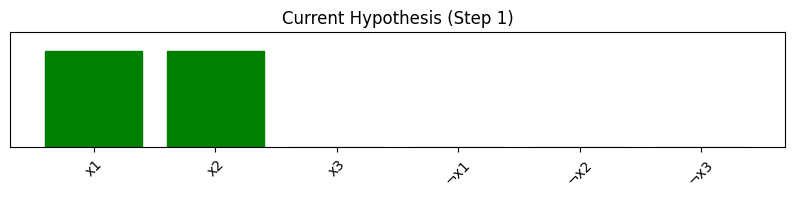

Step 2 | Example: ?11, Label: 1
Current Hypothesis: ['x1', 'x2']


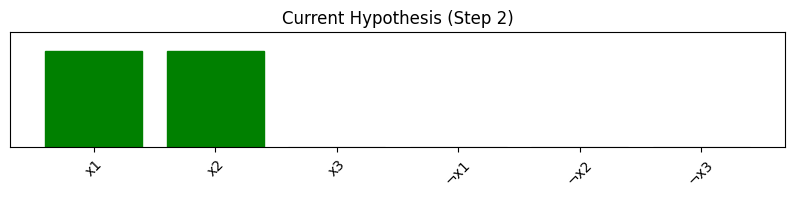

Step 3 | Example: 000, Label: 0
Current Hypothesis: ['x1', 'x2']


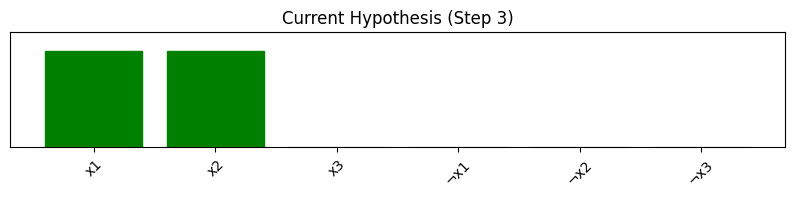

In [12]:
import requests

url = "http://127.0.0.1:5000"

examples = [
    {"example": "1?0", "label": "1"},
    {"example": "?11", "label": "1"},
    {"example": "000", "label": "0"}
]

for i, ex in enumerate(examples, 1):
    response = requests.post(url + "/submit_example", json=ex)
    data = response.json()
    
    print(f"Step {i} | Example: {ex['example']}, Label: {ex['label']}")
    print("Current Hypothesis:", data["current_hypothesis"])
    
    # 🧠 Visualization
    plot_hypothesis(data["current_hypothesis"], step=i)


In [11]:
import matplotlib.pyplot as plt

def plot_hypothesis(hypothesis, step=None):
    literals = [f"x{i+1}" for i in range(3)] + [f"¬x{i+1}" for i in range(3)]

    values = [1 if lit in hypothesis else 0 for lit in literals]

    plt.figure(figsize=(10, 1.5))
    bars = plt.bar(literals, values)

    for bar, v in zip(bars, values):
        bar.set_color('green' if v == 1 else 'lightgray')

    title = "Current Hypothesis"
    if step is not None:
        title += f" (Step {step})"

    plt.title(title)
    plt.ylim(0, 1.2)
    plt.xticks(rotation=45)
    plt.yticks([])
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()
